# 3 Term Nelson Siegel Model

Cubic Spline is first done to create additional data points, NSS model is then applied to inteprolate yield curves. Daily Treasury Par Yield Curves are obtained from the US Department of Treasury.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import splev, splrep

In [2]:


# Send a GET request to the web page
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202305"
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table that contains the data
table = soup.find('table')

# Extract the data from the table
data = []
for row in table.find_all('tr'):
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    if row_data:
        data.append(row_data)

# Convert the extracted data into a pandas DataFrame
df = pd.DataFrame(data)

# Set the first row as the column headers
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Drop rows with NA values
df.dropna(inplace=True)

# Print the resulting DataFrame
print(df)


0   05/01/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.22  5.14  \
1   05/02/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.19  5.06   
2   05/03/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.25  5.08   
3   05/04/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.23  5.04   
4   05/05/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.26  5.13   
5   05/08/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.26  5.14   
6   05/09/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.27  5.18   
7   05/10/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.24  5.13   
8   05/11/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.23  5.14   
9   05/12/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.27  5.16   
10  05/15/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.26  5.24   
11  05/16/2023  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  ...  5.24  5.26   
12  05/17/2023  N/A  N/A  N/A  N/A  N/A 

In [3]:
df.drop(df.columns[2:10], axis=1, inplace=True)

In [4]:
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Add maturity headers to the columns
custom_headers = [
    "Date", "1 Mo", "2 Mo", "3 Mo", "4 Mo", "6 Mo", "1 Yr", "2 Yr", "3 Yr",
    "5 Yr", "7 Yr", "10 Yr", "20 Yr", "30 Yr"
]
df.columns = custom_headers

In [5]:
df

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2,05/03/2023,4.70,5.33,5.26,5.25,5.08,4.70,3.89,3.58,3.37,3.37,3.38,3.79,3.70
3,05/04/2023,5.76,5.24,5.26,5.23,5.04,4.59,3.75,3.47,3.29,3.32,3.37,3.80,3.73
4,05/05/2023,5.59,5.23,5.26,5.26,5.13,4.73,3.92,3.63,3.41,3.41,3.44,3.85,3.76
5,05/08/2023,5.51,5.17,5.31,5.26,5.14,4.79,4.00,3.70,3.49,3.50,3.52,3.92,3.84
6,05/09/2023,5.56,5.16,5.29,5.27,5.18,4.81,4.01,3.67,3.51,3.51,3.53,3.94,3.85
7,05/10/2023,5.50,4.99,5.24,5.24,5.13,4.70,3.90,3.55,3.37,3.40,3.43,3.88,3.80
8,05/11/2023,5.81,4.82,5.20,5.23,5.14,4.70,3.89,3.56,3.36,3.37,3.39,3.82,3.73
9,05/12/2023,5.79,4.87,5.25,5.27,5.16,4.75,3.98,3.65,3.45,3.45,3.46,3.87,3.78
10,05/15/2023,5.64,4.97,5.21,5.26,5.24,4.73,3.99,3.67,3.46,3.48,3.50,3.92,3.84
11,05/16/2023,5.58,4.98,5.23,5.24,5.26,4.88,4.06,3.74,3.52,3.53,3.54,3.96,3.87


In [16]:


# Define the Nelson-Siegel-Svensson function
def nss_curve(x, beta0, beta1, beta2, beta3, tau1, tau2, tau3):
    term1 = beta0 + beta1 * ((1 - np.exp(-x / tau1)) / (x / tau1))
    term2 = beta2 * (((1 - np.exp(-x / tau2)) / (x / tau2)) - np.exp(-x / tau2))
    term3 = beta3 * (((1 - np.exp(-x / tau3)) / (x / tau3)) - np.exp(-x / tau3))
    return term1 + term2 + term3


In [17]:
# Example interest rates for 1 to 10 years
maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])  # Update with the actual maturities
interest_rates = df.iloc[-1].values
interest_rates = interest_rates[1:]

print (interest_rates)


['5.31' '5.31' '5.55' '5.54' '5.52' '5.22' '4.46' '4.10' '3.81' '3.75'
 '3.69' '4.06' '3.90']


In [18]:
# Fit the parameters of the NSS model to the data
p0 = [0.01, -0.01, 0.01, 0.01, 1, 2, 3]  # Initial guess for the parameters
params, _ = curve_fit(nss_curve, maturities, interest_rates, p0)

# Interpolate the yield curve at desired maturities
interpolated_rates = nss_curve(maturities, *params)

# Print the interpolated rates
print(interpolated_rates)


[5.58781446 5.52602977 5.46594067 5.40750629 5.29544278 4.99499353
 4.53095869 4.209459   3.8530002  3.72343199 3.72128556 3.94766118
 3.95649245]


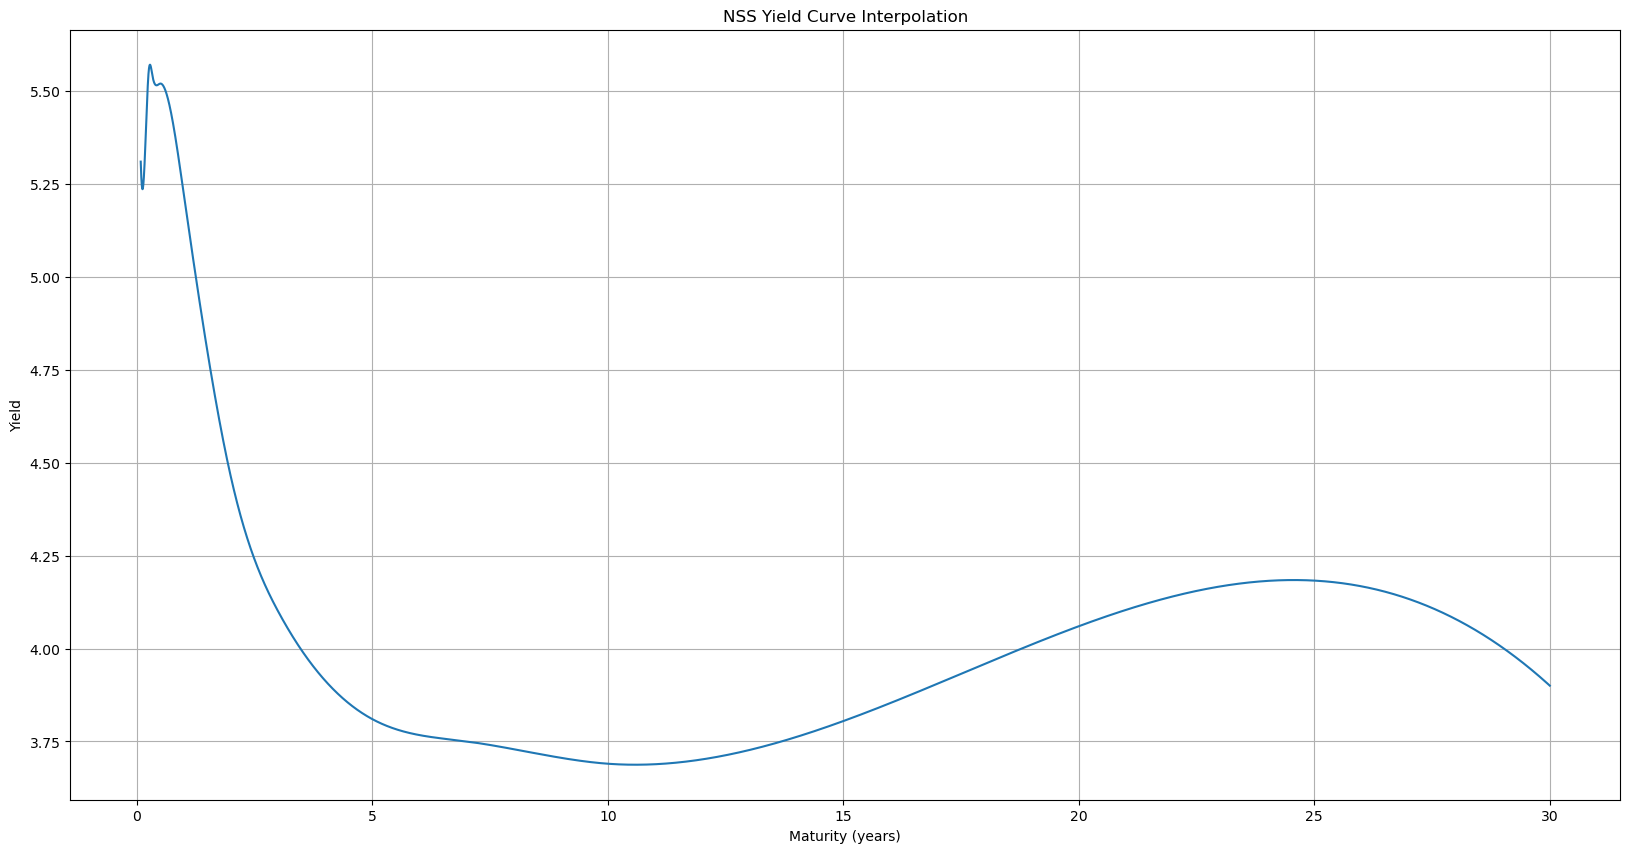

In [25]:

#Perform spline interpolation
interpolated_maturities = np.linspace(min(maturities), max(maturities), 100000)  # Increase the number of data points here
spl = splrep(maturities, interest_rates)
interpolated_rates = splev(interpolated_maturities, spl)

# Set the figure size
plt.figure(figsize=(20, 10))
# Plot the interpolated rates
plt.plot(interpolated_maturities, interpolated_rates)
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('NSS Yield Curve Interpolation')
plt.grid(True)
plt.show()

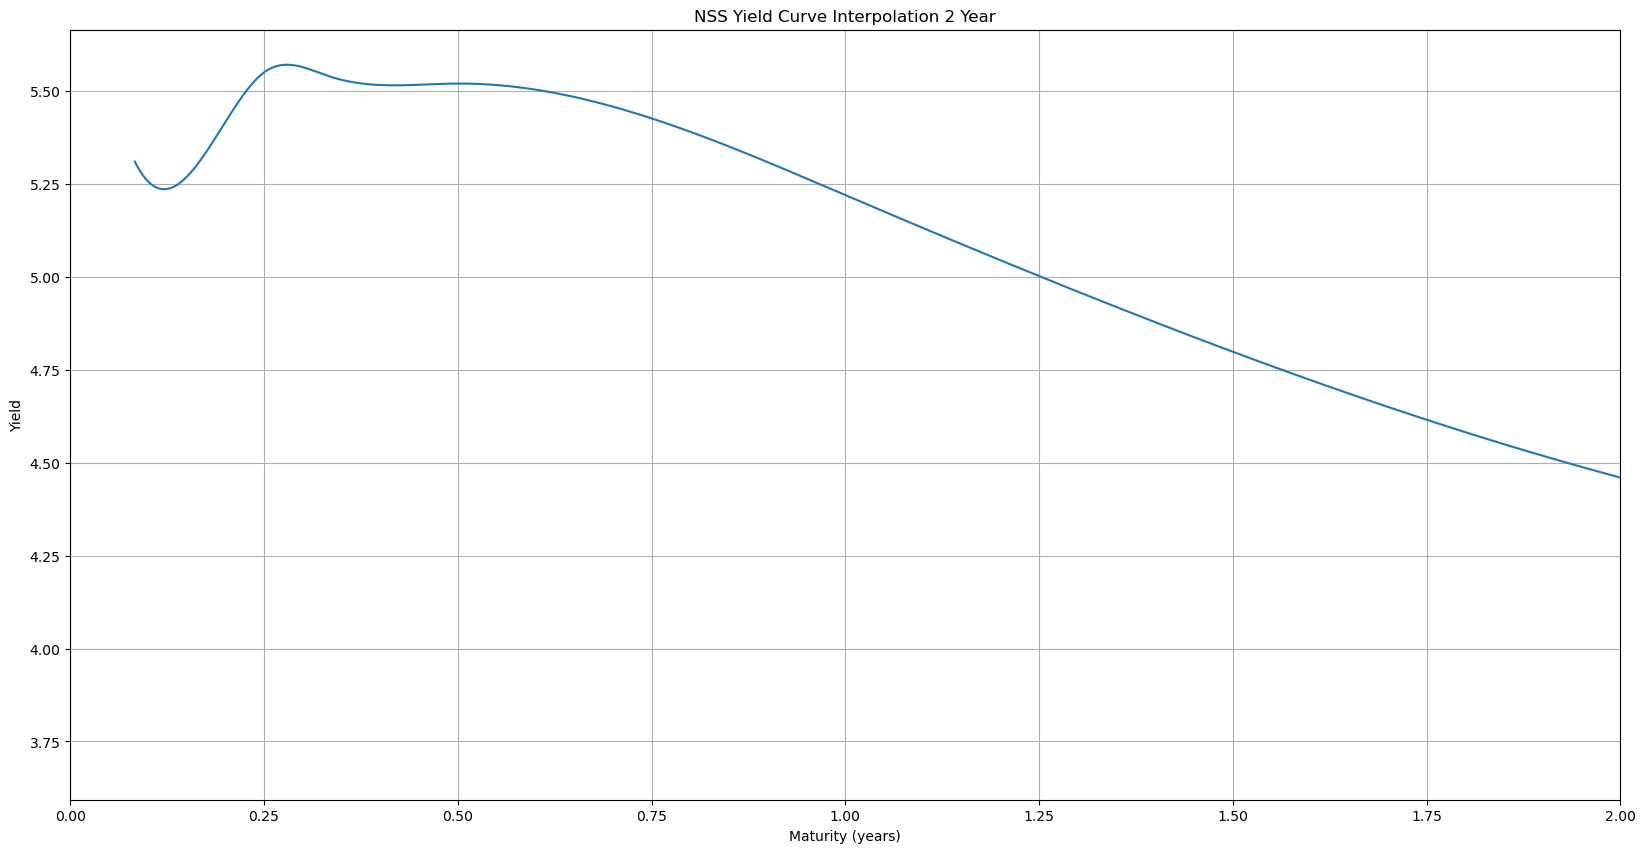

In [36]:
plt.figure(figsize=(20, 10))
# Set the limits for the x-axis and y-axis to zoom in
plt.xlim(0, 2)
plt.grid(True)
plt.plot(interpolated_maturities, interpolated_rates)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('NSS Yield Curve Interpolation 2 Year')




# Show the plot
plt.show()